In [1]:
# import needed packages
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from tensorflow.keras.layers import TextVectorization
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
# data exploration
data = pd.read_csv('book_data.csv', index_col='index')
data.head()

,title,genre,summary
index,,,
0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...
1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ..."
2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...
3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...
4,Taran Wanderer,fantasy,Taran and Gurgi have returned to Caer Dallben...


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4657 entries, 0 to 4656
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    4657 non-null   object
 1   genre    4657 non-null   object
 2   summary  4657 non-null   object
dtypes: object(3)
memory usage: 145.5+ KB


In [4]:
label_column = 'genre'
unique_classes = data[label_column].unique()
sampled_data = pd.DataFrame()
desired_samples_per_class = 600
for class_label in unique_classes:
    class_df = data[data[label_column] == class_label]
    n_samples = min(len(class_df), desired_samples_per_class)
    sampled_class_df = class_df.sample(n=n_samples, random_state=42)
    sampled_data = pd.concat([sampled_data, sampled_class_df])

In [5]:
sampled_data['genre'].value_counts()

genre
fantasy       600
science       600
history       600
horror        600
thriller      600
crime         500
romance       111
psychology    100
sports        100
travel        100
Name: count, dtype: int64

In [6]:
# prepare the data
text_column = 'summary'
label_column = 'genre'
X = sampled_data[text_column]
y = sampled_data[label_column]

In [7]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

In [8]:
max_words = 50000
tokenizer = Tokenizer(num_words=max_words, oov_token="<unk>")
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)

In [9]:
max_len = 200
X_padded = pad_sequences(X_sequences, maxlen=max_len, padding='post', truncating='post')

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [11]:
def get_model(max_len=200, max_words=50000, embedding_dim=64, lstm_units=64, dense_units=128, dropout_rate=0.6, num_classes=num_classes):
    inputs = keras.Input(shape=(max_len,))
    x = layers.Embedding(input_dim=max_words, output_dim=embedding_dim)(inputs)
    x = layers.Bidirectional(layers.LSTM(lstm_units))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(dense_units, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [12]:
model = get_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 200, 64)             │       3,200,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,284,362 (12.53 MB)

 Trainable params: 3,284,106 (12.53 MB)

 Non-trainable params: 256 (1.00 KB)

In [13]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
callbacks = [keras.callbacks.ModelCheckpoint('model.keras', save_best_only=True), reduce_lr]

epochs = 20
batch_size = 32
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 46s 394ms/step - accuracy: 0.1399 - loss: 2.2922 - val_accuracy: 0.1839 - val_loss: 2.2073 - learning_rate: 0.0010
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 38s 385ms/step - accuracy: 0.2500 - loss: 1.9946 - val_accuracy: 0.1699 - val_loss: 2.1401 - learning_rate: 0.0010
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 32s 328ms/step - accuracy: 0.4815 - loss: 1.5373 - val_accuracy: 0.2950 - val_loss: 2.0366 - learning_rate: 0.0010
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 302ms/step - accuracy: 0.6843 - loss: 1.0236 - val_accuracy: 0.2644 - val_loss: 1.9664 - learning_rate: 0.0010
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 306ms/step - accuracy: 0.8003 - loss: 0.6402 - val_accuracy: 0.3946 - val_loss: 1.8543 - learning_rate: 0.0010
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 33s 337ms/step - accuracy: 0.8517 - loss: 0.4688 - val_accuracy: 0.3436 - val_loss: 2.1518 - learning_rate: 0.0010
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 31s 319ms/step - accuracy: 0.8721 - loss: 0.

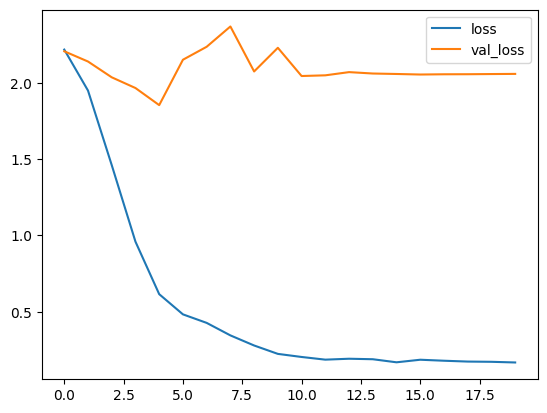

In [14]:
metrics = pd.DataFrame(history.history)
metrics[['loss', 'val_loss']].plot()
plt.show()

In [15]:
y_pred_probs = model.predict(X_val)
y_pred = tf.argmax(y_pred_probs, axis=1).numpy()
model = keras.models.load_model('model.keras')
accuracy = model.evaluate(X_val, y_val)
print('Test accuracy:', accuracy[1])

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.3869 - loss: 1.8770
Test accuracy: 0.39463600516319275


In [16]:
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

       crime       0.58      0.57      0.57       100
     fantasy       0.48      0.40      0.44       120
     history       0.51      0.53      0.52       120
      horror       0.47      0.52      0.49       120
  psychology       0.26      0.25      0.26        20
     romance       0.12      0.13      0.12        23
     science       0.59      0.57      0.58       120
      sports       0.33      0.35      0.34        20
    thriller       0.47      0.53      0.50       120
      travel       0.10      0.05      0.07        20

    accuracy                           0.49       783
   macro avg       0.39      0.39      0.39       783
weighted avg       0.48      0.49      0.48       783



In [17]:
# make predictions on new data
def predict_genre(text):
    """Predicts the genre of a given text."""
    text_sequence = tokenizer.texts_to_sequences([text])
    text_padded = pad_sequences(text_sequence, maxlen=max_len, padding='post', truncating='post')
    prediction_probabilities = model.predict(text_padded)
    predicted_class_index = tf.argmax(prediction_probabilities, axis=1).numpy()[0]
    predicted_genre = label_encoder.inverse_transform([predicted_class_index])[0]
    return predicted_genre

In [18]:
# The Martian
new_text_example_1 = 'An astronaut is presumed dead after a fierce storm and left behind by his crew on Mars, only to find he has survived.'
predicted_genre_1 = predict_genre(new_text_example_1)
print('For the book "The Martian", the model predicted the genre to be', predicted_genre_1, 'when the actual genre is Science Fiction.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
For the book "The Martian", the model predicted the genre to be horror when the actual genre is Science Fiction.


In [19]:
# Pride and Prejudice
new_text_example_2 = 'In 19th-century England, the Bennet sisters navigate societal expectations and the complexities of love and marriage.'
predicted_genre_2 = predict_genre(new_text_example_2)
print('For the book "Pride and Prejudice", the model predicted the genre to be', predicted_genre_2, 'when the actual genre is Romance.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
For the book "Pride and Prejudice", the model predicted the genre to be thriller when the actual genre is Romance.


In [20]:
# The Da Vinci Code
new_text_example_3 = 'A Harvard symbologist and a cryptologist investigate a murder in the Louvre and uncover a religious conspiracy..'
predicted_genre_3 = predict_genre(new_text_example_3)
print('For the book "The Da Vinci Code", the model predicted the genre to be', predicted_genre_2, 'when the actual genre is Mystery.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
For the book "The Da Vinci Code", the model predicted the genre to be thriller when the actual genre is Mystery.
